**Goal**: Build a model to predict the difference in hourly payment, based on the size and the industry of the company. 

We will examine linear regression & decision trees. 

In [1]:
# Import all data libraries

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

## Import all Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Other import
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection


### Prepare the data

In [2]:
# Load files

# UK paygap data
gap = pd.read_csv('paygap_v2.csv')

gap.head(2)

,Unnamed: 0,EmployerName,DiffMedianHourlyPercent,DiffMedianBonusPercent,MaleBonusPercent,FemaleBonusPercent,MaleLowerQuartile,FemaleLowerQuartile,MaleTopQuartile,FemaleTopQuartile,CompanyLinkToGPGInfo,EmployerSize,RegAddress.PostTown,CompanyCategory,SICCode.SicText_1,EmployerSizeCenter,SIC_SECTOR
0,0,"""Bryanston School"",Incorporated",28.2,0.0,0.0,0.0,24.4,75.6,51.5,48.5,https://www.bryanston.co.uk/employment,500 to 999,DORSET,"PRI/LTD BY GUAR/NSC (Private, limited by guara...",85310 - General secondary education,750.0,Services
1,1,"""RED BAND"" CHEMICAL COMPANY, LIMITED",-2.7,37.5,15.6,66.7,20.3,79.7,18.1,81.9,NaN,250 to 499,EDINBURGH,Private Limited Company,47730 - Dispensing chemist in specialised stores,350.0,Utility Services


In [3]:
# Keep only relevant columns
cols = ['EmployerName', 'DiffMedianHourlyPercent', 'FemaleTopQuartile', 'EmployerSize', 
        'RegAddress.PostTown', 'EmployerSizeCenter', 'SIC_SECTOR' ]

gap = gap[cols]

gap.rename(columns={'EmployerName': 'Employer', 'DiffMedianHourlyPercent': 'HourlyDiff', 
                    'DiffMedianHourlyPercent': 'HourlyDiff', 
                   'RegAddress.PostTown': 'Town',
                   'EmployerSizeCenter': 'MedianSize',
                   'SIC_SECTOR': 'Sector'}, inplace=True)

# Drop nulls from MedianSize

gap = gap.dropna(subset = ['MedianSize'])
gap = gap.dropna(subset = ['Sector'])


print('null values:', gap['HourlyDiff'].isnull().values.sum())
print(len(gap))
gap.sample(5)


null values: 0
8264


,Employer,HourlyDiff,FemaleTopQuartile,EmployerSize,Town,MedianSize,Sector
3431,FUJIFILM DIOSYNTH BIOTECHNOLOGIES UK LIMITED,11.8,27.0,500 to 999,BILLINGHAM,750.0,Manufacturing
3933,HARGREAVE HALE LIMITED,63.7,3.1,250 to 499,BLACKPOOL,350.0,Financials
3093,EXPEDITORS INTERNATIONAL (UK) LIMITED,14.0,20.0,500 to 999,BEDFONT,750.0,Retail Trade
2736,"E.H.BOOTH & CO.,LIMITED",8.0,36.3,1000 to 4999,PRESTON,3500.0,Utility Services
9323,TOTALJOBS GROUP LIMITED,15.6,23.5,250 to 499,LONDON,350.0,Retail Trade


In [46]:
gap.to_csv('gap_with_sector.csv')

In [4]:
# Understanding the target variable

gap['HourlyDiff'].describe()

count    8264.000000
mean       11.795172
std        16.086091
min      -164.000000
25%         0.300000
50%         8.800000
75%        21.600000
max       121.200000
Name: HourlyDiff, dtype: float64

                   HourlyDiff  FemaleTopQuartile  MedianSize
HourlyDiff           1.000000          -0.196552   -0.044518
FemaleTopQuartile   -0.196552           1.000000    0.005804
MedianSize          -0.044518           0.005804    1.000000


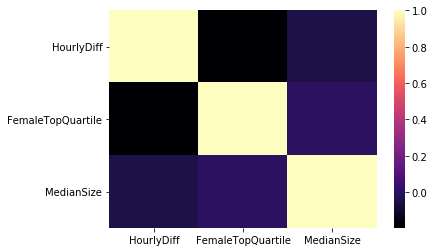

In [5]:
# Looking for collinearity

corr_mat = gap.corr()
print(corr_mat)
plt.figure()
sns.heatmap(corr_mat, cmap = 'magma')


### Split the dataset

In [6]:
#I kepp all columns as predictor, besides the target column

X = gap.drop(['HourlyDiff'], axis=1) #.values.reshape(-1,1)
y = gap['HourlyDiff']



In [7]:
X_train,X_test, y_train, y_test = train_test_split(X, y) 
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(6198, 6)
(6198,)
(2066, 6)
(2066,)


In [8]:
def shape_dummy(X, y):
    train = X.join(y)
    dummies = pd.get_dummies(train['Sector'])
    train = train.join(dummies)

    X = (train
         .drop('HourlyDiff', axis = 1)
         .drop('Employer', axis = 1)
         .drop('EmployerSize', axis = 1)
         .drop('Town', axis = 1)
         .drop('Sector', axis = 1)
         .drop('FemaleTopQuartile', axis = 1))
    y = train['HourlyDiff']

    return X, y

X, y = shape_dummy(X_train, y_train)

### Run linear models

In [9]:
#Instantiate all linear models

lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()

In [10]:
# Function for calculating algo metrics
def linear_model_metrics_for_algo(algo, X, y):
    predictions = algo.predict(X)
    mse = np.sqrt(mean_squared_error(predictions, y))
    r2 = algo.score(X, y)
    residuals = (y - predictions)
    print('mean squeared error', mse)
    print('R2 Score: ', r2)
    plt.hist(residuals)
    return mse

# Function for training model and calculating algo metrics
def get_linear_model_metrics(X, y, algo):
    pvals = feature_selection.f_regression(X, y)[1] #I know that 1 is the p-value on the f_regression function
    algo.fit(X, y)
    linear_model_metrics_for_algo(algo, X, y)
    y_int = algo.intercept_
    coefficients = algo.coef_
    print('Intercept: ', y_int)
    print('Coefficients: ', coefficients)
    print('P-Values: ',pvals)
    return algo

mean squeared error 15.507413516938115
R2 Score:  0.05157337427547992
Intercept:  11.800603961803693
Coefficients:  [-2.26662733e-04  4.08245559e+00 -7.73907208e+00  7.62052506e+00
  3.31725997e-01 -5.00156974e+00 -6.77190326e+00 -4.59126234e+00
 -5.16492441e+00  1.13377961e+00 -1.50326173e-01  1.48571902e+01
  1.39338156e+00]
P-Values:  [1.59233650e-05 4.74011836e-02 1.02106943e-03 1.21511578e-32
 9.56683322e-01 1.60457807e-07 1.88272009e-01 3.03761719e-08
 2.15336488e-18 3.46936689e-03 1.01546218e-01 8.40935616e-08
 6.87948464e-01]


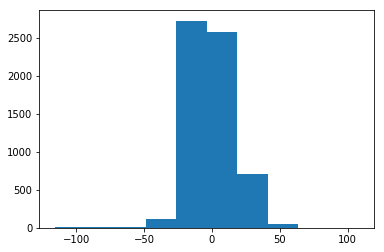

In [11]:
lm_algo = get_linear_model_metrics(X, y, lm)

mean squeared error 15.899547173879737
R2 Score:  0.003001480956256408
Intercept:  12.24109614765946
Coefficients:  [-0.00024195  0.         -0.          0.         -0.         -0.
 -0.         -0.         -0.          0.         -0.          0.
  0.        ]
P-Values:  [1.59233650e-05 4.74011836e-02 1.02106943e-03 1.21511578e-32
 9.56683322e-01 1.60457807e-07 1.88272009e-01 3.03761719e-08
 2.15336488e-18 3.46936689e-03 1.01546218e-01 8.40935616e-08
 6.87948464e-01]


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

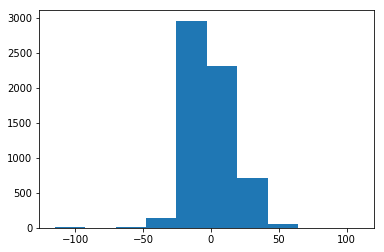

In [12]:
get_linear_model_metrics(X, y, lasso)

mean squeared error 15.507475484122061
R2 Score:  0.05156579448862042
Intercept:  11.832467336585173
Coefficients:  [-2.26368667e-04  3.99158060e+00 -7.59454284e+00  7.57579786e+00
  2.99130412e-01 -5.01178567e+00 -6.12359214e+00 -4.60808151e+00
 -5.18797479e+00  1.10099524e+00 -1.82693797e-01  1.44238120e+01
  1.31735469e+00]
P-Values:  [1.59233650e-05 4.74011836e-02 1.02106943e-03 1.21511578e-32
 9.56683322e-01 1.60457807e-07 1.88272009e-01 3.03761719e-08
 2.15336488e-18 3.46936689e-03 1.01546218e-01 8.40935616e-08
 6.87948464e-01]


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

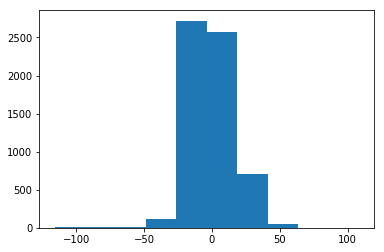

In [13]:
get_linear_model_metrics(X, y, ridge)

mean squeared error 15.884067533210896
R2 Score:  0.004941871567249678
Intercept:  12.205479314690795
Coefficients:  [-2.41541502e-04  0.00000000e+00 -0.00000000e+00  3.54884045e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00]
P-Values:  [1.59233650e-05 4.74011836e-02 1.02106943e-03 1.21511578e-32
 9.56683322e-01 1.60457807e-07 1.88272009e-01 3.03761719e-08
 2.15336488e-18 3.46936689e-03 1.01546218e-01 8.40935616e-08
 6.87948464e-01]


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

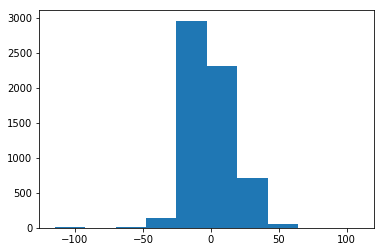

In [14]:
get_linear_model_metrics(X, y, enet)

### Scaling

In [15]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline


In [16]:
pipeline = Pipeline([('std_scaler', StandardScaler()),
                    ('poly_features', PolynomialFeatures(degree = 4))])

In [17]:
x_scaled = pipeline.fit_transform(X)

### Rerun models after scaling

In [18]:
#Instantiate the models again

lm = LinearRegression()
lasso = Lasso()
ridge = Ridge()
enet = ElasticNet()


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.450063580825875
R2 Score:  0.05857539675572254
Intercept:  -377553163.5648335
Coefficients:  [-2.42285313e-13  7.17093264e+07  3.07056405e+08 ... -6.24212906e+05
  2.73174159e+08  2.07087508e+08]
P-Values:  [           nan 1.59233650e-05 4.74011836e-02 ... 3.62150413e-04
 6.87862987e-01 6.87948464e-01]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

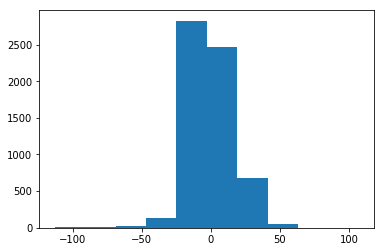

In [19]:
get_linear_model_metrics(x_scaled, y, lm)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.496828807054236
R2 Score:  0.052867644868001544
Intercept:  12.424958979814148
Coefficients:  [ 0.         -0.          0.         ... -0.          0.
 -0.00015884]
P-Values:  [           nan 1.59233650e-05 4.74011836e-02 ... 3.62150413e-04
 6.87862987e-01 6.87948464e-01]


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

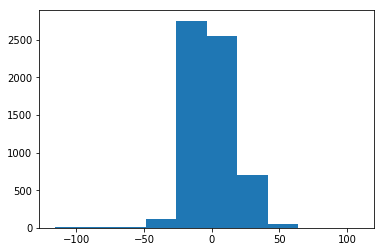

In [20]:
get_linear_model_metrics(x_scaled, y, lasso)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.434983420513559
R2 Score:  0.06041227016365236
Intercept:  11.60777777527072
Coefficients:  [ 0.00000000e+00 -4.12753657e-01  2.76782943e-06 ...  2.14927260e-08
 -5.32704817e-07  9.99355339e-05]
P-Values:  [           nan 1.59233650e-05 4.74011836e-02 ... 3.62150413e-04
 6.87862987e-01 6.87948464e-01]


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

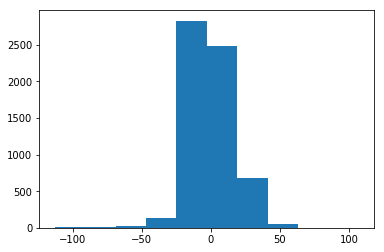

In [21]:
get_linear_model_metrics(x_scaled, y, ridge)

/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Lina/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


mean squeared error 15.48568125659685
R2 Score:  0.05422978267815903
Intercept:  12.505036116923375
Coefficients:  [ 0.         -0.          0.         ... -0.          0.
 -0.00016298]
P-Values:  [           nan 1.59233650e-05 4.74011836e-02 ... 3.62150413e-04
 6.87862987e-01 6.87948464e-01]


/Users/Lina/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

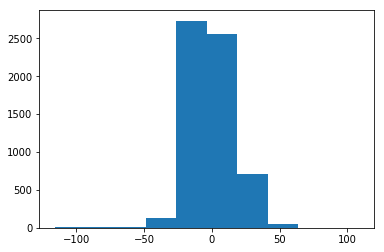

In [22]:
get_linear_model_metrics(x_scaled, y, enet)

Scaling the data didn't improve the results. We will now try regression tree.

### Regression tree

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [24]:
# Create test predictor & target

X_validate, y_true = shape_dummy(X_test, y_test)

In [25]:
depths = []
rmses = []

min_rmse = None
best_model = None

for depth in range(3, 15):
    regr_ = DecisionTreeRegressor(max_depth=depth)
    regr_.fit(X, y)
    y_pred = regr_.predict(X_validate)
    rmse = np.sqrt(mean_squared_error(y_true.as_matrix(), y_pred))

    if min_rmse is None or rmse < min_rmse:
        best_model = regr_
        min_rmse = rmse
    
    depths.append(depth)
    rmses.append(rmse)

In [26]:
# Based on sklearn/tree/export.py ( https://goo.gl/Y5y6et )
from sklearn.tree import _tree
def fix_rmse_recursive(tree, node_id):
    tree.impurity[node_id] = np.sqrt(tree.impurity[node_id])
    
    left_child = tree.children_left[node_id]
    right_child = tree.children_right[node_id]

    if left_child != _tree.TREE_LEAF:
        fix_rmse_recursive(tree, left_child)#, criterion=criterion, parent=node_id, depth=depth + 1)
        fix_rmse_recursive(tree, right_child)#, c, criterion=criterion, parent=node_id, depth=depth + 1)

best_model.criterion = 'rmse'
fix_rmse_recursive(best_model.tree_, 0)

/Users/Lina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


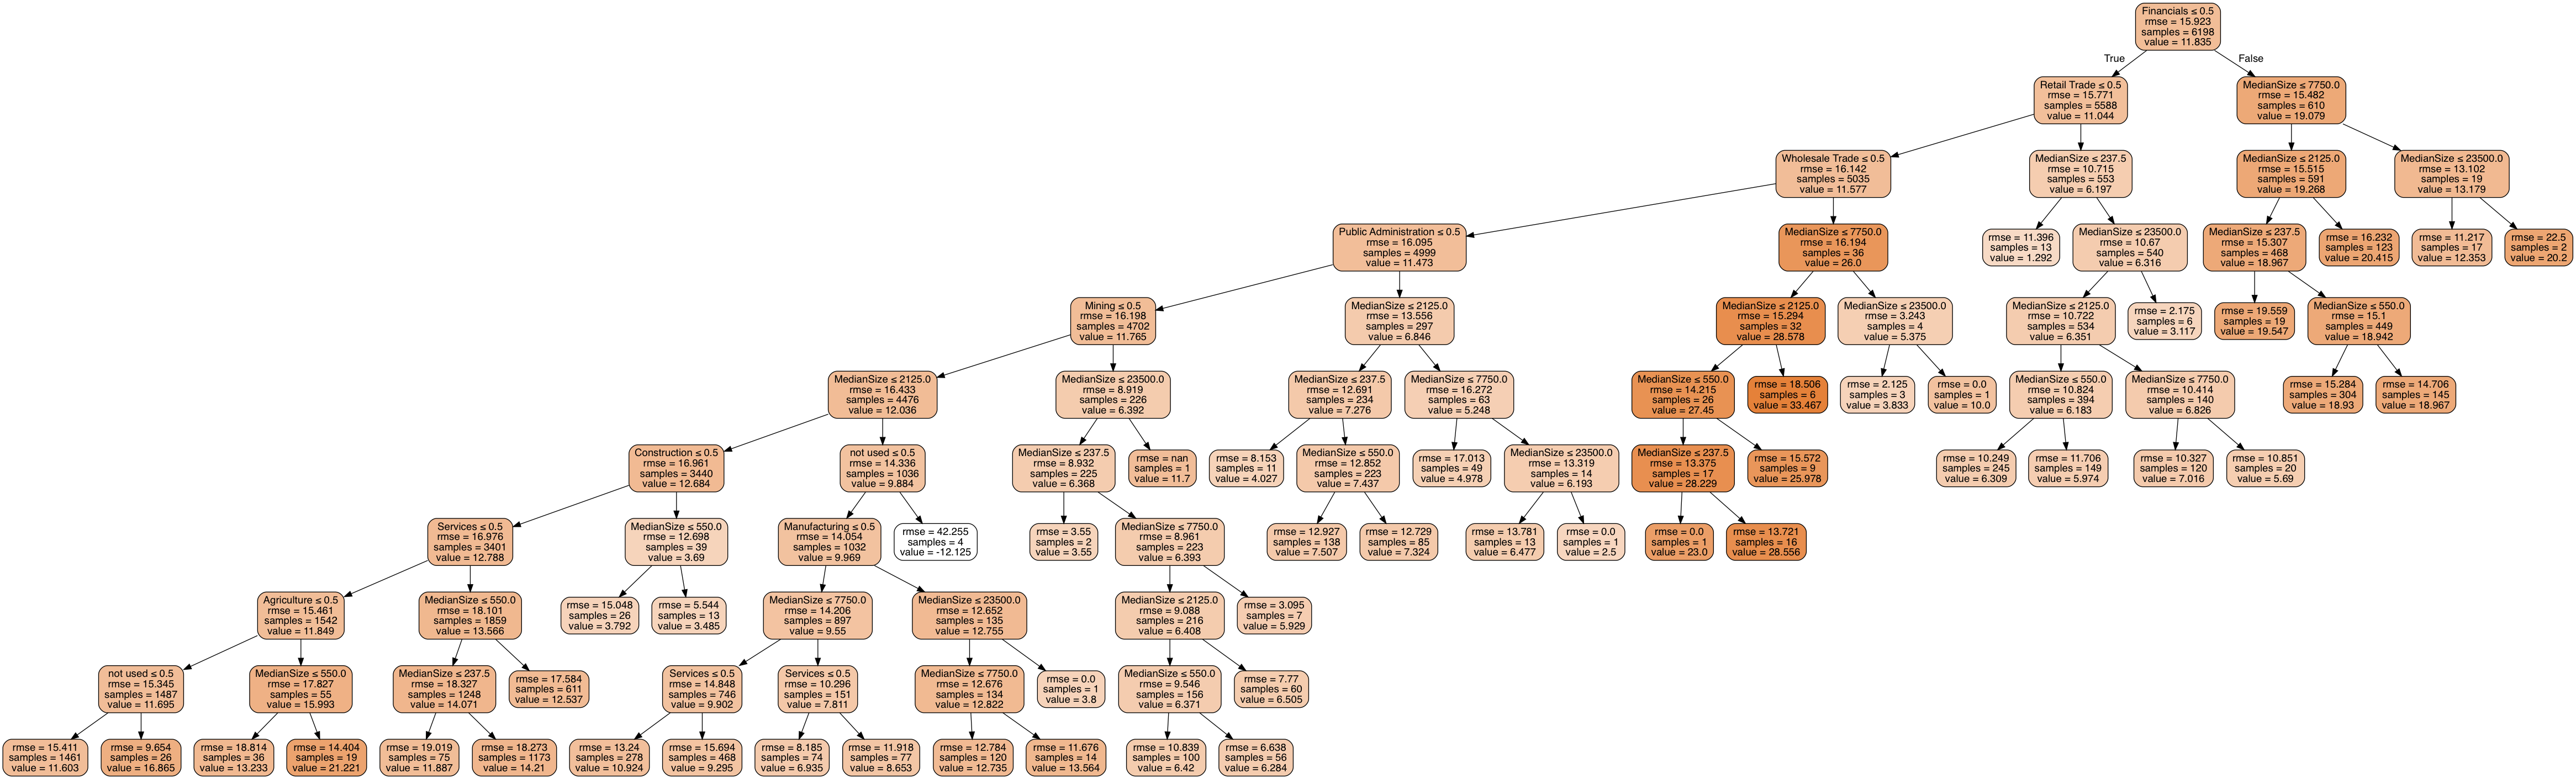

In [27]:
feature_cols = list(X)
dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,  filled=True, rounded=True, special_characters=True,
                feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

mean squeared error 16.131316107833978
R2 Score:  0.05110859965703318


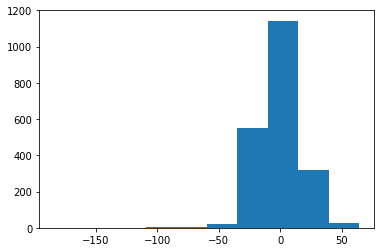

In [28]:
# Run linear model on test data

linear_rmse = linear_model_metrics_for_algo(lm_algo, X_validate, y_true)

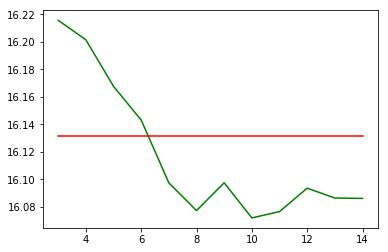

In [29]:
plt.plot(depths, rmses,                         'g-',
         depths, [linear_rmse for i in depths], 'r-')

In [41]:
# Create dataframe with industries, company sizes & target values


X_all = gap.drop(['HourlyDiff'], axis=1)
y_all = gap['HourlyDiff']

X_all, y_all = shape_dummy(X_all, y_all)

y_all_pred = best_model.predict(X_all)
y_all_series = pd.Series(y_all_pred, index=y_all.index, name='y_pred')

uniq = X_all.join(y_all_series).drop_duplicates()

dumies = (uniq
          .drop('MedianSize', axis = 1)
          .drop('y_pred', axis = 1))

# https://stackoverflow.com/a/45622556
sector = pd.Series(dumies.idxmax(axis=1), name='Sector')

cols = ['Sector', 'MedianSize', 'y_pred']
df_results = uniq[['MedianSize', 'y_pred']].join(sector)[cols].sort_values(['Sector', 'MedianSize'])
df_results.head()


,Sector,MedianSize,y_pred
2987,Agriculture,125.0,13.233333
8,Agriculture,350.0,13.233333
373,Agriculture,750.0,21.221053
239,Agriculture,3500.0,10.923741
110,Construction,350.0,3.792308


In [43]:
#df_results.to_csv('results.csv')

In [45]:
df_results.nlargest(10, 'y_pred')

,Sector,MedianSize,y_pred
1280,Wholesale Trade,3500.0,33.466667
82,Wholesale Trade,350.0,28.556250
272,Wholesale Trade,750.0,25.977778
8092,Wholesale Trade,125.0,23.000000
373,Agriculture,750.0,21.221053
113,Financials,3500.0,20.415447
827,Financials,35000.0,20.200000
245,Financials,125.0,19.547368
2,Financials,750.0,18.966897
128,Financials,350.0,18.930263


In [47]:
df_results.nsmallest(10, 'y_pred')

,Sector,MedianSize,y_pred
2079,not used,3500.0,-12.125000
2317,Retail Trade,125.0,1.292308
4992,Public Administration,35000.0,2.500000
4143,Retail Trade,35000.0,3.116667
526,Construction,750.0,3.484615
3161,Mining,125.0,3.550000
110,Construction,350.0,3.792308
4626,Manufacturing,35000.0,3.800000
2772,Wholesale Trade,12000.0,3.833333
2359,Public Administration,125.0,4.027273
